## Import Functions

In [1]:
import requests
import urllib
from datetime import datetime
from bs4 import BeautifulSoup
import gzip
import zipfile
import io
import json
import os
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandarallel import pandarallel
false=False
null=None
from datetime import datetime
import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)
from IPython.display import display
import pickle

## Local Functions

In [2]:
def return_loc(x): ## Extracts location of the user
    try:
        return "{}, {}".format(eval(x)['short_name'],eval(x)['country'])
    except:
        return None

## Download the projects dataset

In [3]:
links=[]
page=requests.get('https://webrobots.io/kickstarter-datasets/').content
soup=BeautifulSoup(page,'html.parser')
for each in soup.findAll('a'):
    if each.text=='CSV':
            links.append(each['href'])
len_links=len(links)
print("total_number of data files:",len_links)

total_number of data files: 52


In [4]:
if os.path.isfile('links_used.txt'):
    with open('links_used.txt','r') as links_used_txt:
        files_extracted=links_used_txt.readlines()[0].split(",")
    df=pd.read_csv('data_file.csv')
    print("data files loaded: {}/{} of total".format(len(files_extracted),len_links))
else:
    df=pd.DataFrame()
    files_extracted=[]
len_links=len(links)
for count,link in enumerate(links):
    df_length=df.shape[0]
    filename=link.split('/')[-1].split(".")[0]
    if filename in files_extracted:
#         print(count,") Already extracted",filename)
        continue
    print("current length:",df_length)
    print(count,") Currently extracting:",filename)
    r = requests.get(link)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    for c,i in enumerate(z.filelist):
        df=pd.concat([df,pd.read_csv(z.open(i))],axis=0,sort=False)
        df=df.drop_duplicates(subset=['id']).reset_index(drop=True)
    print(df.shape[0]-df_length,"rows added")
    df.to_csv('data_file.csv',index_label=False)
    files_extracted.append(filename)
    with open('links_used.txt','w') as file1:
        file1.write(",".join(files_extracted))
    if count==2:
        break
print("# of Kickstarter products loaded:",df.shape[0])
df=df.iloc[:,:-8].dropna(axis=0,subset=['category']) # remove almost empty columns


C:\Users\User\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (6,11,12,14,15,19,20,21,25,31,32,38,42,45,46) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


data files loaded: 52/52 of total
# of Kickstarter products loaded: 361114


### extract categories information

In [5]:
categories={}

def extract_cat_id(x):
    tempx=eval(x)
    categories[tempx['id']]=tempx['name']

df.category.apply(extract_cat_id)
print("Total number of categories:",len(categories))

Total number of categories: 170


## Creating a dataframe with relevant columns

In [6]:
def to_date(x):
    try:
        return datetime.fromtimestamp(x)
    except:
        return None
    
def made_by_user(created,creator_id,idx): # made_by_user returns the number of projects made before by the user
    try:
        return data[(data.created_at>created)&(data.creator_id==creator_id)].count().iloc[0]
    except:
        print(created,creator_id,idx)

data=df.loc[:,['id','name','blurb','goal','spotlight','staff_pick','country']]
data['creator_id']=df.creator.apply(lambda x:x.partition('id\":')[2].partition(',')[0])
data['location']=df.location.apply(return_loc)
data['category_id']=df.category.apply(lambda x:eval(x)['id'])
data['category_parent_id']=df.category.apply(lambda x:eval(x).get('parent_id',None))
data['created_at']=df.created_at.apply(datetime.fromtimestamp)
data['launched_at']=df.launched_at.apply(to_date)
data['deadline']=df.deadline.apply(datetime.fromtimestamp)
data['time_to_launch']=data.launched_at-data.created_at
data['time_to_deadline']=data.deadline-data.launched_at
data[['pledged','backers_count']]=df.loc[:,['usd_pledged','backers_count']]
data['offset']=data.pledged-data.goal
data['state']=df.loc[:,['state']].astype('category')
print("current data status:",data.shape)
data=data[(data.state=='successful') | (data.state=='failed')].dropna()
data['successful']=data.state=='successful'
data['failed']=data.state!='successful'
print("data status after dropping NAs:",data.shape)
data=data.reset_index(drop=True)
product_ids=set(data.id.astype('int64'))
data=data.set_index(['id'],drop=True)

products_downloaded=set(data.index.astype('int64'))
    
if os.path.isfile('data.csv'):
    data_loaded=pd.read_csv('data.csv').set_index('id',drop=True)
    data_loaded['created_at']=data_loaded.created_at.apply(lambda x:datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
    data_loaded['launched_at']=data_loaded.launched_at.apply(lambda x:datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
    data_loaded['time_to_launch']=pd.to_timedelta(data_loaded.time_to_launch)
    data_loaded['time_to_deadline']=pd.to_timedelta(data_loaded.time_to_deadline)
    products_loaded=set(data_loaded.index.astype('int64'))
    products_to_load=products_downloaded-products_loaded   
    data_missing =data.loc[products_to_load]
    if data_missing.shape[0]!=0:
        data_missing['user_created_before']=data_missing.apply(lambda x: made_by_user(x['created_at'],x['creator_id'],x.index),axis=1)
        data=pd.concat([data_loaded,data_missing])
    else:
        data['user_created_before']=data_loaded['user_created_before']

data.to_csv('data.csv',index_label='id')

current data status: (361113, 20)
data status after dropping NAs: (262636, 22)


# Understaing the data

### Projects Success Ratio

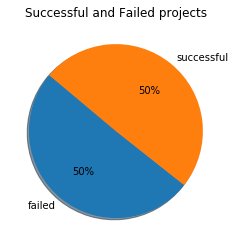

In [7]:
ax=data.groupby('state').count().name.plot(kind='pie',autopct='%1.0f%%',shadow=True, startangle=140)
ax.set_ylabel(None)
ax.set_title('Successful and Failed projects')
plt.show()

### Most of the projects are done by Americans

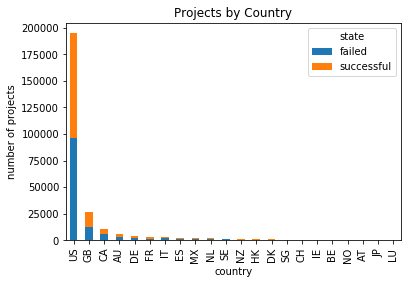

In [8]:
ax=data.groupby(['country','state']).count().unstack('state').name.reindex(data.groupby(['country']).count().sort_values(by='name',ascending=False).index).plot(kind='bar',stacked=True)
ax.set_ylabel('number of projects')
ax.set_title('Projects by Country')
plt.show()


In [9]:
from geopy.geocoders import Nominatim
import geopandas

geolocator = Nominatim(user_agent="kickstarter_project")
locations=pd.DataFrame(data.location.value_counts())

read=dict()
coordinates_dict={}
with open('locations.txt', 'r',encoding='utf-16') as readfile:
    for row in readfile:
        row_split=row[:-1].split(':')
        read[row_split[0]]=eval(row_split[1])
    
with open('locations.txt', 'a',encoding='utf-16') as writefile:
    i=0
    for loc,row in locations.iterrows():
        if loc not in read.keys():
            try:
                gcode=geolocator.geocode(loc)
                writefile.write("{}:({},{})\n".format(loc,gcode.latitude,gcode.longitude))
            except:
                print(loc)
                
by_location=data.groupby('location').count().name.reset_index(drop=False)
by_location.columns=['location','count']
by_location['LonLat']=by_location.location.map(read)

gdf=geopandas.GeoDataFrame(by_location,geometry=geopandas.points_from_xy(by_location.LonLat.apply(lambda x: x[1]), by_location.LonLat.apply(lambda x: x[0])))

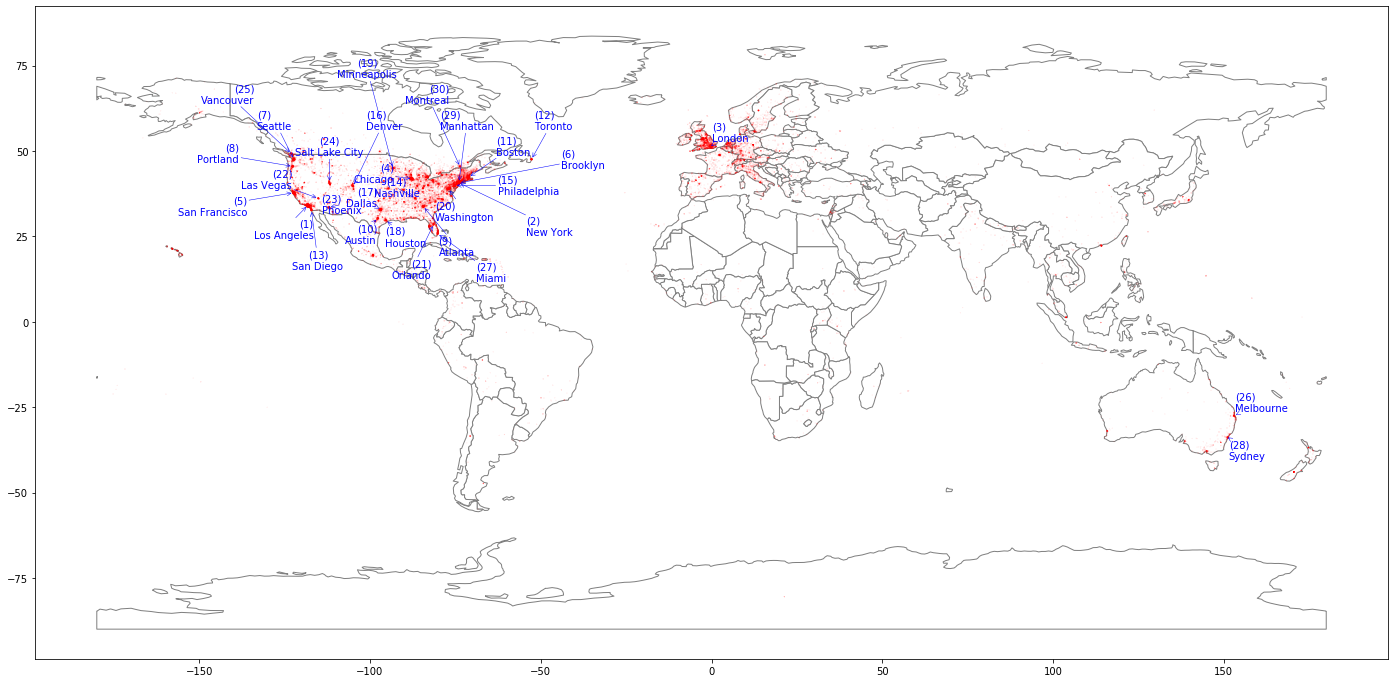

In [10]:
from adjustText import adjust_text

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax=world.plot(edgecolor='gray',color='white',figsize=(30, 12))
annotations=[]
tops=gdf.sort_values('count',ascending=False)[0:30].reset_index(drop=True)
tops['location']=tops.location.apply(lambda x:x.split(",")[0])
tops['coords'] = tops['geometry'].apply(lambda x: x.representative_point().coords[:])
tops['coords'] = [coords[0] for coords in tops['coords']]
for idx, row in tops.iterrows():
    annotations.append(plt.annotate(s="({})\n{}".format(idx+1,row['location']), xy=row['coords'],color='b'))
gdf.plot(ax=ax, c='r', markersize=gdf['count']/1000)
adjust_text(annotations,arrowprops=dict(arrowstyle="->", color='b', lw=0.5))
plt.show()

### Kickstarter popularity has risen in 2004-2005. The less kickstarter is popular, projects are more successful

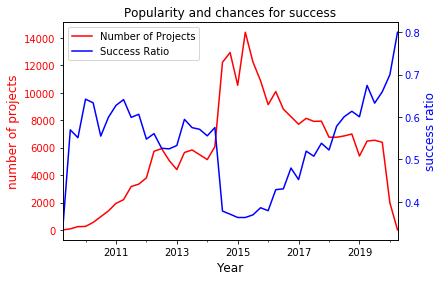

In [11]:
fig=plt.figure()

plt.title('Popularity and chances for success')
ax1=data.groupby(pd.Grouper(key='launched_at',freq='3M')).count().name.plot(kind='line',c='red',label='Number of Projects')
ax2=ax1.twinx()
data.groupby(pd.Grouper(key='launched_at',freq='3M')).mean().successful.plot(kind='line',c='blue',ax=ax2,label='Success Ratio')
ax2.spines
ax1.set_xlabel('Year',fontdict={'size':12})
ax1.set_ylabel('number of projects',fontdict={'color':'red','size':12})
ax1.axes.tick_params(axis='y',labelcolor='red')
ax2.set_ylabel('success ratio',fontdict={'color':'blue','size':12})
ax2.axes.tick_params(axis='y',labelcolor='blue')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()


plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

### Most projects are created and launched in the same day. A project deadline usually determined 20-40 days after launch

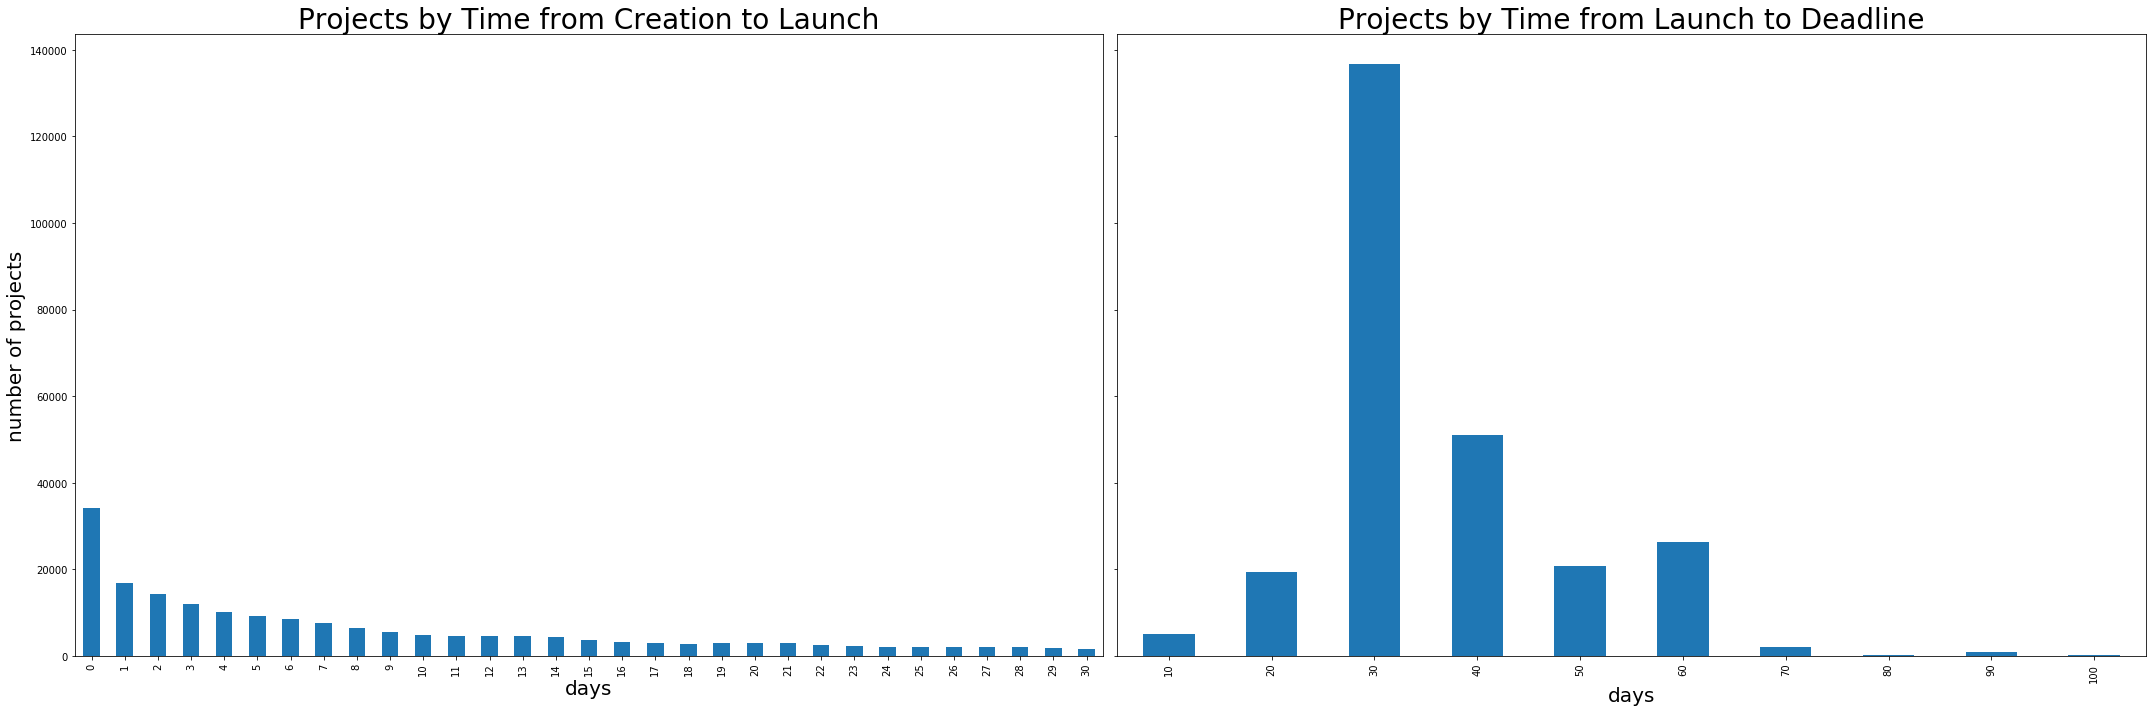

In [12]:
fig, ax = plt.subplots(1,2,figsize=(30,10),sharey=True)
data.groupby(data.time_to_launch.dt.days).count().name.plot(kind='bar',ax=ax[0])
ax[0].set_xlim([-.5,30.5])
ax[0].set_xlabel('days',fontdict={'size':20})
ax[0].set_ylabel('number of projects',fontdict={'size':20})
ax[0].set_title('Projects by Time from Creation to Launch',fontsize=28)


data.groupby(data.time_to_deadline.dt.ceil('10d').dt.days).count().name.plot(kind='bar',ax=ax[1])
ax[1].set_title('Projects by Time from Launch to Deadline',fontsize=28)

ax[1].set_xlabel('days',fontdict={'size':20})
fig.tight_layout()
plt.show()

### The higher the Goal, the less chance for the project to reach it

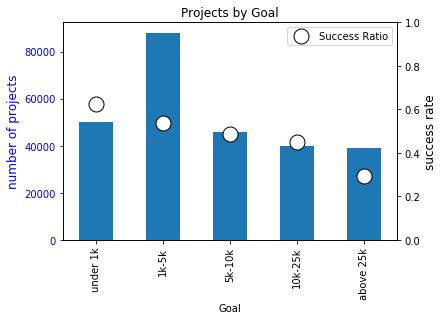

In [13]:
fig=plt.figure()

ax=pd.cut(data.goal,bins=[0,1000,5000,10000,25000,float("inf")],labels=['under 1k','1k-5k','5k-10k', '10k-25k', 'above 25k'],duplicates='drop',precision=0).value_counts().sort_index().plot(kind='bar')
ax.set_title('Projects by Goal')
ax.set_ylabel('number of projects',fontdict={'color':'blue','size':12})
ax.set_xlabel('Goal')
ax.axes.tick_params(axis='y',labelcolor='blue')


ax2=ax.twinx()

temp=pd.DataFrame()
temp['goal']=pd.cut(data.goal,bins=[0,1000,5000,10000,25000,float("inf")],labels=['under 1k','1k-5k','5k-10k', '10k-25k', 'above 25k'],duplicates='drop',precision=0)
temp['success']=data.successful
temp.groupby('goal').mean().plot(kind='line',style='ro',marker='o',markersize=15,markeredgecolor='black', ax=ax2,c='white',label='success ratio')
ax2.set_ylabel('success rate',fontdict={'color':'black','size':12})
ax2.set_ylim([0,1])
ax2.legend(['Success Ratio'])
ax2.axes.tick_params(axis='y',labelcolor='black')
plt.show()

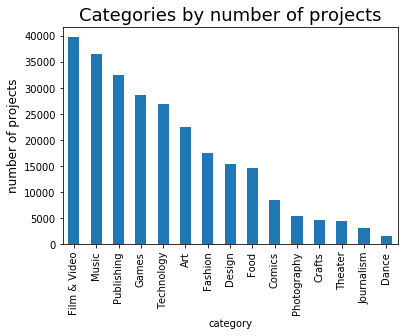

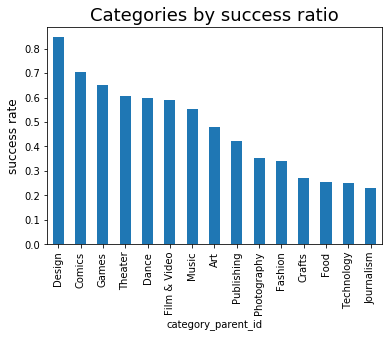

In [14]:
fig=plt.figure()
ax=data.groupby(data.category_parent_id.map(categories)).count().name.sort_values(ascending=False).plot(kind='bar')
ax.set_title('Categories by number of projects',fontdict={'size':18})
ax.set_ylabel('number of projects',fontdict={'size':12})
ax.set_xlabel('category')


fig=plt.figure()
ax2=data.groupby(data.category_parent_id.map(categories)).mean().successful.sort_values(ascending=False).plot(kind='bar')
ax2.set_title('Categories by success ratio',fontdict={'size':18})
ax2.set_ylabel('success rate',fontdict={'color':'black','size':12})
ax.set_xlabel('category')



plt.show()

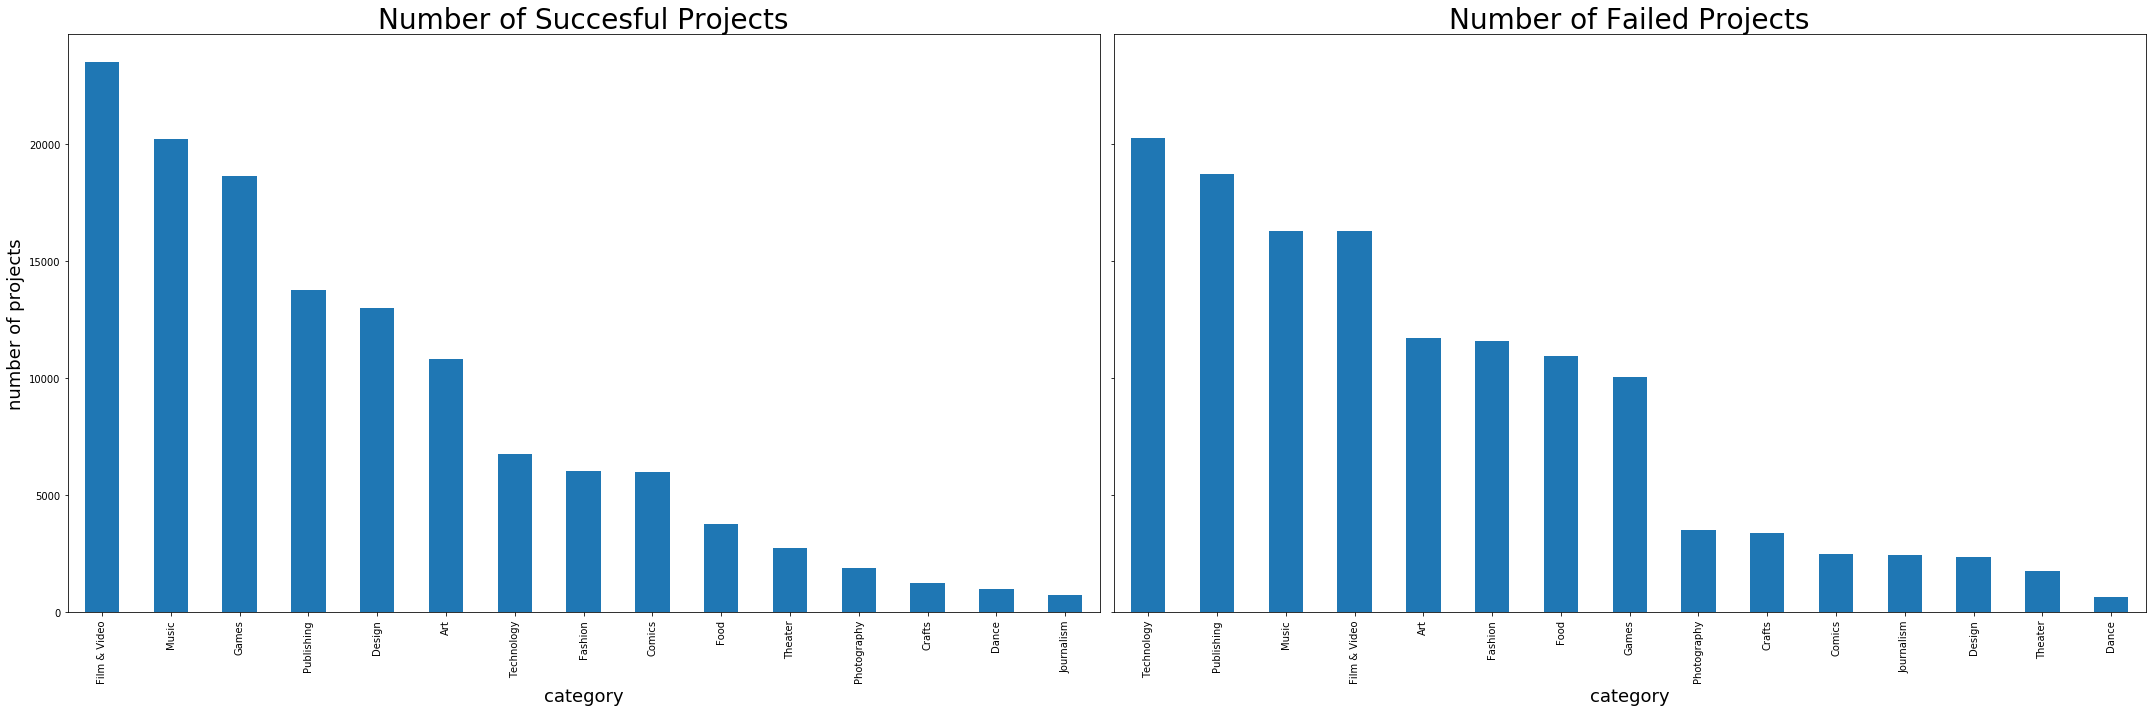

In [15]:
fig, ax= plt.subplots(1,2,figsize=(30,10),sharey=True)


data.groupby(data.category_parent_id.map(categories)).sum().successful.sort_values(ascending=False).plot(kind='bar', ax=ax[0])
ax[0].set_title('Number of Succesful Projects',fontsize=28)
ax[0].set_xlabel('category',fontsize=18)
ax[0].set_ylabel('number of projects',fontsize=18)

data.groupby(data.category_parent_id.map(categories)).sum().failed.sort_values(ascending=False).plot(kind='bar',ax=ax[1])
ax[1].set_xlabel('category',fontsize=18)
ax[1].set_title('Number of Failed Projects',fontsize=28)

fig.tight_layout()


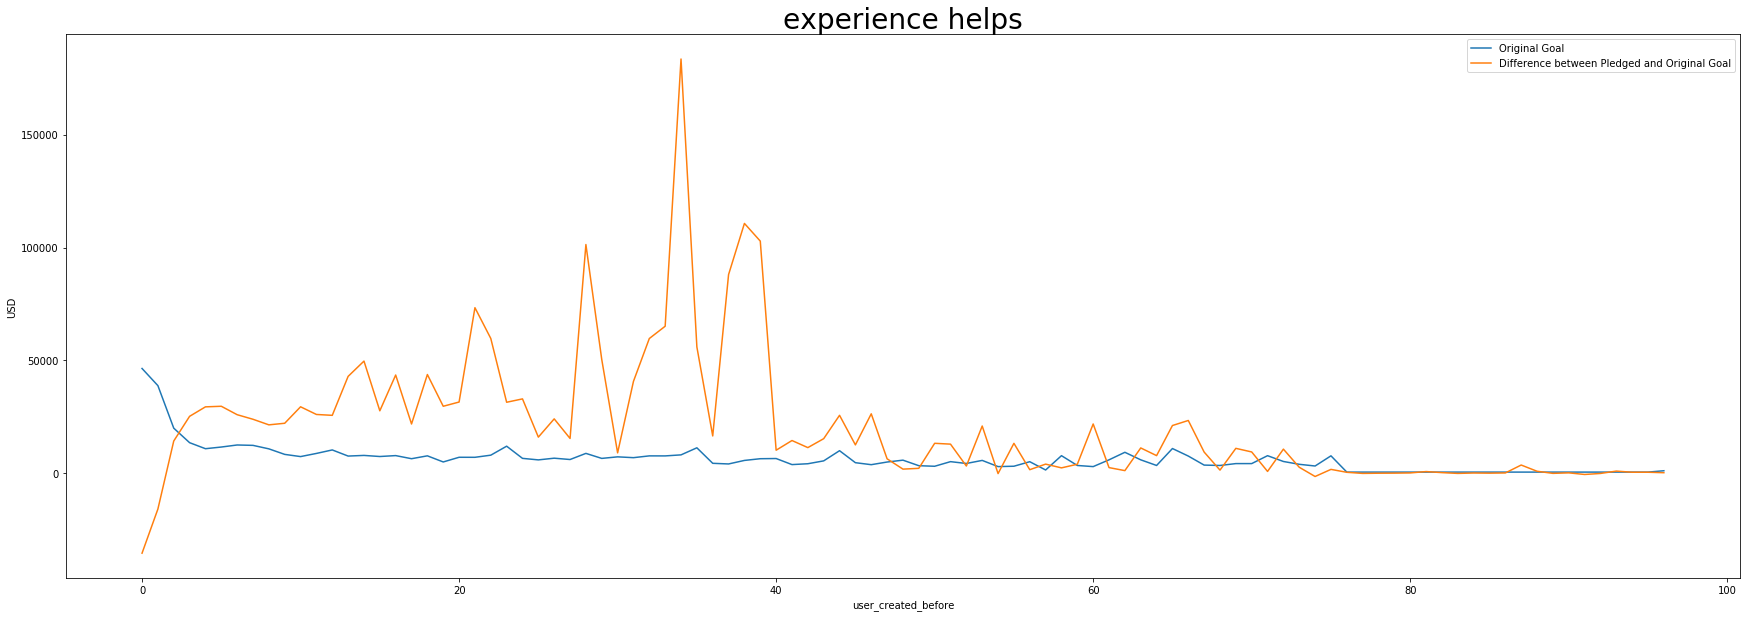

In [16]:
fig=plt.figure(figsize=(30,10))
user_created_before=data.groupby('user_created_before')
ax=user_created_before.mean().goal.plot(kind='line',label='Original Goal')
ax.set_title('experience helps',fontsize=28)
ax.set_xlabel('projects done by user')
ax.set_ylabel('USD')
user_created_before.mean().offset.plot(kind='line',ax=ax,label='Difference between Pledged and Original Goal')
ax.legend()
plt.show()

# Wordclouds

In [17]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [18]:
text = " ".join(review for review in data.blurb)
wc = WordCloud(stopwords=STOPWORDS,background_color="white", max_words=500, width=400, height=400, random_state=1).generate(text)

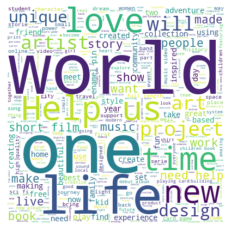

In [19]:
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [20]:
WC=list()
WC_cat=list()
for count,category in enumerate(data.category_parent_id.unique()):
    sample_text = " ".join(review for review in data[data.category_parent_id==category].blurb)
    WC.append(WordCloud(stopwords=STOPWORDS,background_color="white", max_words=500, width=400, height=400, random_state=1).generate(sample_text))
    WC_cat.append(category)

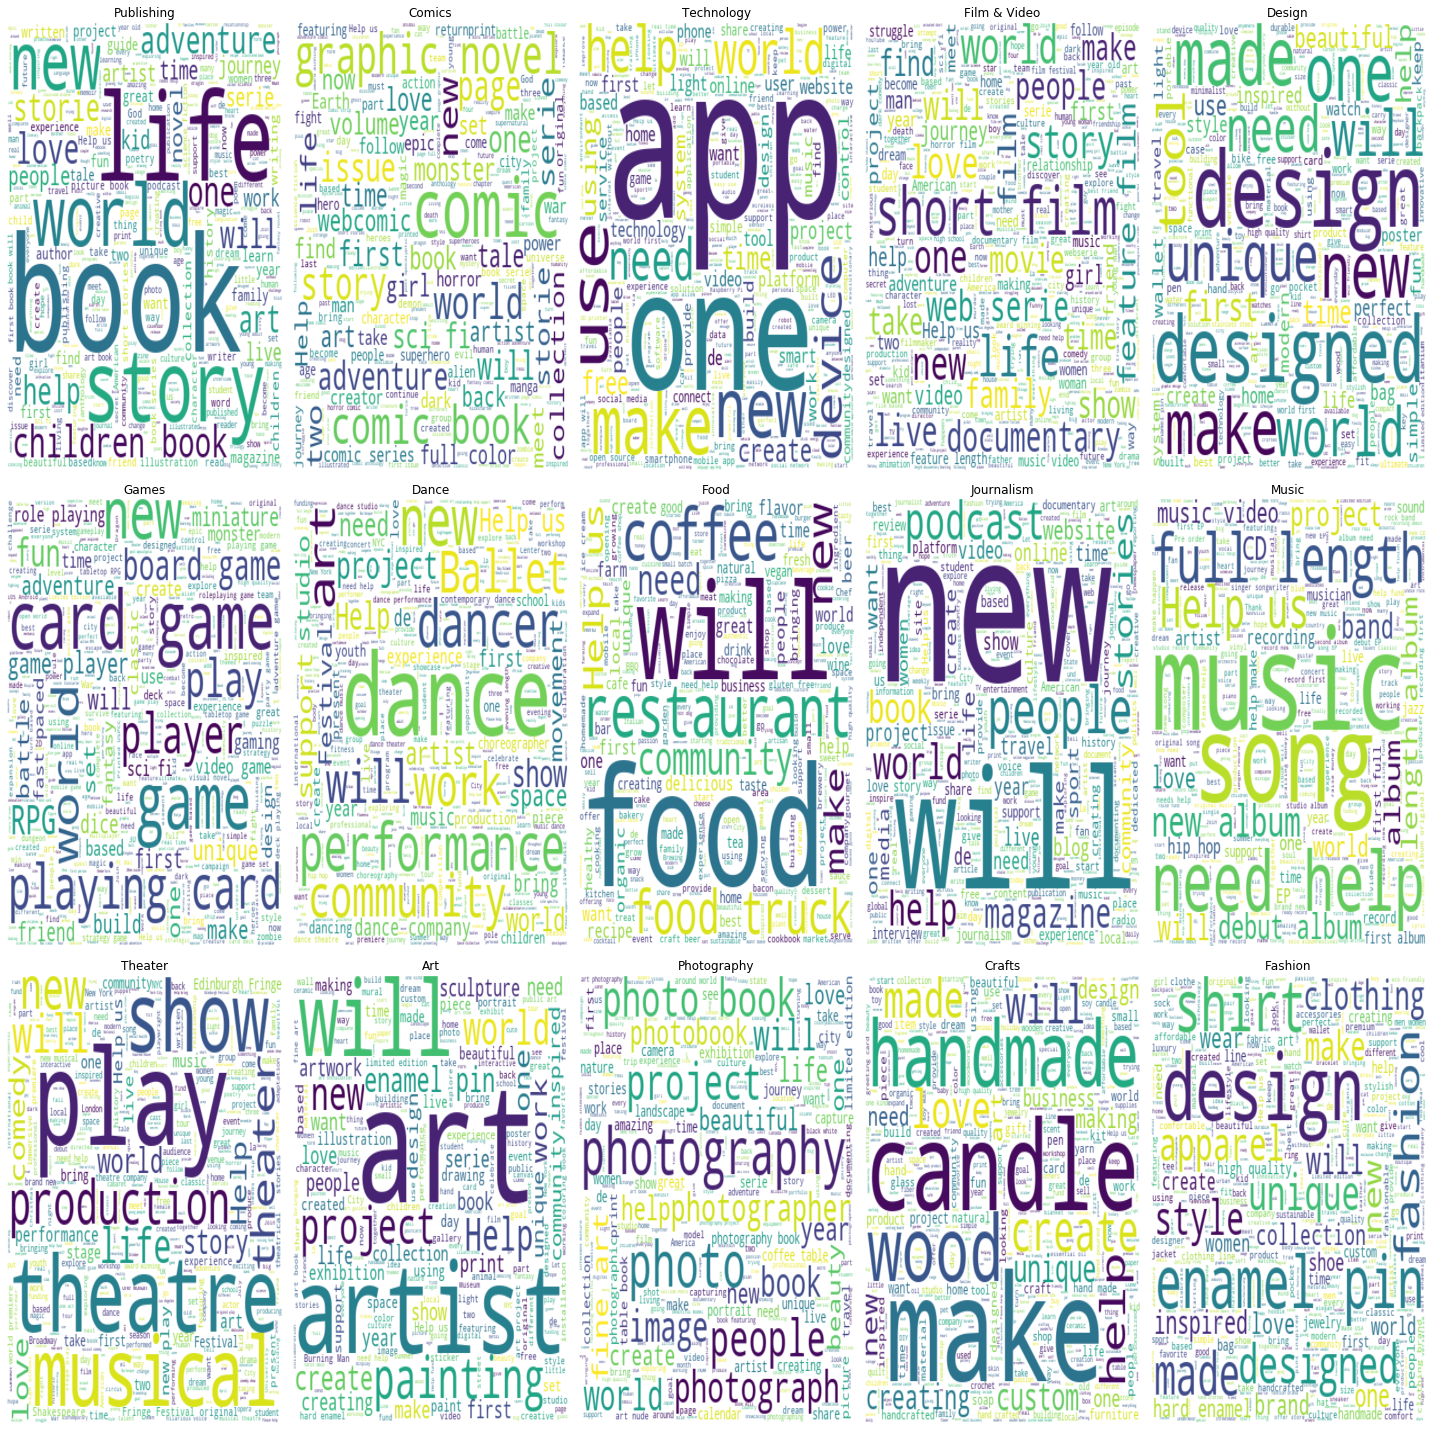

In [21]:
fig, axes = plt.subplots(nrows=3,ncols=5,squeeze=True,figsize=(20,20))
for i,ax in enumerate(axes):
    for j,bx in enumerate(ax):
#     plt.title(categories[category])
        bx.imshow(WC[i*5+j], interpolation='bilinear', aspect='auto')
        bx.set_title(categories[WC_cat[i*5+j]])
        bx.axis("off")
fig.tight_layout()
plt.show()

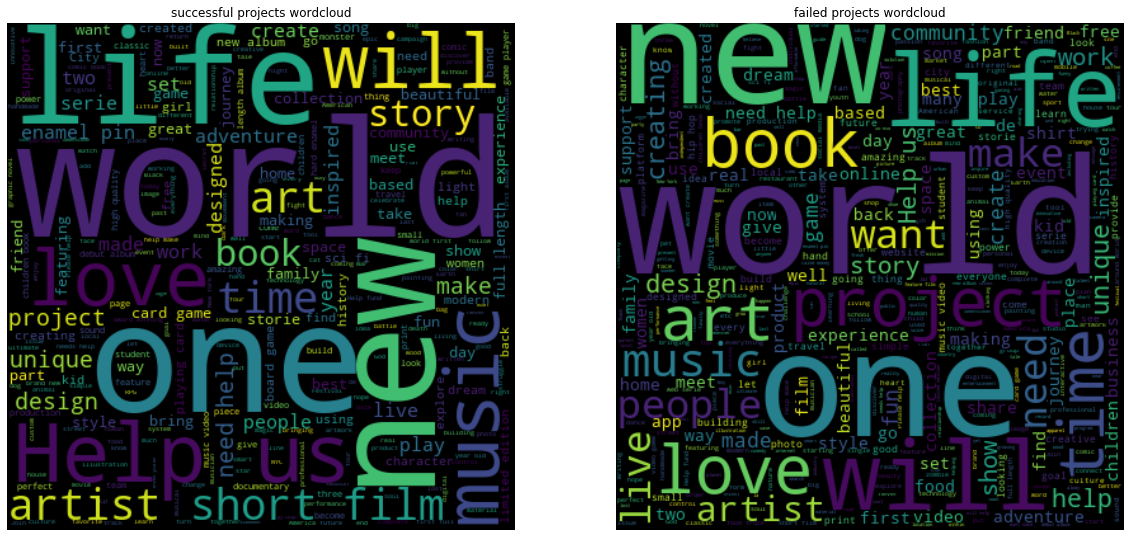

In [22]:
fig, axes = plt.subplots(nrows=1,ncols=2,squeeze=True,figsize=(20,20))
text_successful=" ".join(review for review in data[data.state=='successful'].blurb)
wc_succesful=WordCloud(stopwords=STOPWORDS,background_color="black", max_words=500, width=400, height=400, random_state=1).generate(text_successful)
axes[0].imshow(wc_succesful, interpolation='bilinear')
axes[0].set_title("successful projects wordcloud")
axes[0].axis("off")
text_failed=" ".join(review for review in data[data.state=='failed'].blurb)
wc_failed=WordCloud(stopwords=STOPWORDS,background_color="black", max_words=500, width=400, height=400, random_state=1).generate(text_failed)
axes[1].imshow(wc_failed, interpolation='bilinear')
axes[1].set_title("failed projects wordcloud")
axes[1].axis("off")
plt.show()

# Predicting Successful Projects

## Creating a labeled data to create the classification
### Data includes:
* Original goal
* was it staff picked
* how many projects has the user created before
* time between creation and launch
* time between launch and deadline
* is the user American

the data is classified by the success of the project

In [23]:
import random
def define_classes(y_column,data):
    new_items=set()
    y=data.loc[:,[y_column]]
    indices=dict(enumerate(y.index))
    unique_values,counts=np.unique(y,return_counts=True)
    min_counts=min(counts)
    for value,count in zip(unique_values,counts):
        wheres=np.where(y==value)[0]
        if count>min_counts:
            new_sample=random.sample(set(wheres),min_counts)
        else:
            new_sample=wheres
#         new_items.update(new_sample)
        new_items.update({indices[k] for k in new_sample})
    y_balanced=y[y.index.isin(new_items)]
    data_balanced=data[data.index.isin(new_items)]       
    return y_balanced.values.ravel(),data_balanced
    
    
y,balanced_data=define_classes('successful',data)
X=balanced_data.loc[:,['goal','staff_pick','user_created_before']]
X['staff_pick']=X.staff_pick.astype('bool')
X['time_to_launch']=balanced_data.time_to_launch.dt.days
X['time_to_deadline']=balanced_data.time_to_deadline.dt.days
X['us']=balanced_data.country=='US'

In [24]:
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

In [25]:
def classify(desc,X,y,classification_model,log,**kwargs):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)
    model = classification_model().set_params(**kwargs)
    row = {'name':classification_model.__name__,
           'datashape':X.shape,
           'params':model.get_params()}
    model_id = classification_model.__name__ + "-" + desc
    if model_id in log.keys() and row['datashape'][0]<log[model_id]['datashape'][0]:
        return 
    else:
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)
        row.update({'model':model,'accuracy':metrics.accuracy_score(y_test,y_pred.astype('bool'))})
        log[model_id]=row

def GridSearch(X,y,classification_model,params):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)
    clf = GridSearchCV(classification_model(), param_grid=params,cv=10,n_jobs=4)
    clf.fit(X_train,y_train)
    return clf.best_params_

In [26]:
log={}

## Classification models

In [27]:
import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)

# if os.path.exists('log.pkl'):
#     with open('log.pkl','rb') as readpickle:
#         log=pickle.load(readpickle)


###Model 1: Decision Tree Classifier
classify("baseline",X,y,DecisionTreeClassifier,log)    
tuned_parameters = {'max_depth':np.linspace(1, 32, 16, endpoint=True),
                   'max_leaf_nodes':range(10,40,5),
                   'min_samples_split':range(2,30,8)}
best_params=GridSearch(X,y,DecisionTreeClassifier,tuned_parameters)
classify("with parameter tuning",X,y,DecisionTreeClassifier,log,**best_params)

### Model 2: Stochastic Gradient Descent
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled=scaler.fit_transform(X)
tuned_parameters = {'penalty':['L1','L2','elasticnet'],
                    'loss':["hinge",'modified_huber','log'],
                    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]}
classify("baseline",X_scaled,y,SGDClassifier,log)
best_params=GridSearch(X,y,SGDClassifier,tuned_parameters)
classify("with parameter tuning",X_scaled,y,SGDClassifier,log,**best_params)

### Model 3: Logistic Regression
from sklearn.linear_model import LogisticRegression

classify("baseline",X_scaled,y,LogisticRegression,log)

### Model 4: Random Forest

from sklearn.ensemble import RandomForestClassifier

tuned_parameters = {'max_depth':np.linspace(1, 32, 16, endpoint=True),
                   'max_leaf_nodes':range(10,40,5),
                   'min_samples_split':range(2,30,8)}

classify("baseline",X,y,RandomForestClassifier,log)
best_params=GridSearch(X,y,RandomForestClassifier,tuned_parameters)
classify("with parameter tuning",X,y,RandomForestClassifier,log,**best_params)

### Model 5: K-Nearest Neighbors

from sklearn.neighbors import KNeighborsClassifier as knn

tuned_parameters = {'n_neighbors':range(3,15,3),
                    'leaf_size':[10,15,30,45],
                    'p':range(1,5,1)}

classify("baseline",X,y,knn,log)
best_params=GridSearch(X,y,knn,tuned_parameters)
classify("with parameter tuning",X,y,knn,log,**best_params)

### Model 6: Naive Bayes
from sklearn.naive_bayes import GaussianNB as gnb
classify("baseline",X,y,gnb,log)

### Model 7: XG_boost

from xgboost import XGBClassifier as xgb

tuned_parameters = {
        'min_child_weight': range(3,15,5),
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': range(5,10),
        'n_estimators': [120]} 
classify("baseline",X,y,xgb,log)
grid = RandomizedSearchCV(estimator=xgb(), param_distributions=tuned_parameters, scoring='accuracy', n_jobs=4, cv=5, verbose=3).fit(X,y)
classify("with parameter tuning",X,y,xgb,log,**grid.best_params_)

### Model 8: LightGBM

from lightgbm import LGBMClassifier
classify("basline",X,y,LGBMClassifier,log)

tuned_parameters = {'boosting':['gbdt','dart'],
                    'num_leaves':[10,20,31,40],
                    'min_data_in_leaf':range(5,35,5),
                    'max_depth':range(5,30,5),
                    'feature_fraction':[.5,.7,.75,.8,.9]}
grid = RandomizedSearchCV(estimator=LGBMClassifier(), param_distributions=tuned_parameters, scoring='accuracy', n_jobs=4, cv=5, verbose=3).fit(X,y)
classify("with parameter tuning",X,y,LGBMClassifier,log,**grid.best_params_)

with open('log.pkl','wb') as writepickle:
    pickle.dump(log,writepickle)
    
pd.DataFrame.from_dict(log,orient='index').sort_values('accuracy',ascending=False)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\User\Anaconda3\lib\site-p

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  4.9min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   52.2s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  1.6min finished


name  \
LGBMClassifier-with parameter tuning                  LGBMClassifier   
LGBMClassifier-basline                                LGBMClassifier   
XGBClassifier-with parameter tuning                    XGBClassifier   
XGBClassifier-baseline                                 XGBClassifier   
RandomForestClassifier-with parameter tuning  RandomForestClassifier   
DecisionTreeClassifier-with parameter tuning  DecisionTreeClassifier   
RandomForestClassifier-baseline               RandomForestClassifier   
LogisticRegression-baseline                       LogisticRegression   
KNeighborsClassifier-with parameter tuning      KNeighborsClassifier   
DecisionTreeClassifier-baseline               DecisionTreeClassifier   
SGDClassifier-baseline                                 SGDClassifier   
KNeighborsClassifier-baseline                   KNeighborsClassifier   
SGDClassifier-with parameter tuning                    SGDClassifier   
GaussianNB-baseline                                       GaussianNB   

                                                datashape  \
LGBMClassifier-with parameter tuning          (260228, 6)   
LGBMClassifier-basline                        (260228, 6)   
XGBClassifier-with parameter tuning           (260228, 6)   
XGBClassifier-baseline                        (260228, 6)   
RandomForestClassifier-with parameter tuning  (260228, 6)   
DecisionTreeClassifier-with parameter tuning  (260228, 6)   
RandomForestClassifier-baseline               (260228, 6)   
LogisticRegression-baseline                   (260228, 6)   
KNeighborsClassifier-with parameter tuning    (260228, 6)   
DecisionTreeClassifier-baseline               (260228, 6)   
SGDClassifier-baseline                        (260228, 6)   
KNeighborsClassifier-baseline                 (260228, 6)   
SGDClassifier-with parameter tuning           (260228, 6)   
GaussianNB-baseline                           (260228, 6)   

                                                                                         params  \
LGBMClassifier-with parameter tuning          {'boosting_type': 'gbdt', 'class_weight': None...   
LGBMClassifier-basline                        {'boosting_type': 'gbdt', 'class_weight': None...   
XGBClassifier-with parameter tuning           {'base_score': 0.5, 'booster': 'gbtree', 'cols...   
XGBClassifier-baseline                        {'base_score': 0.5, 'booster': 'gbtree', 'cols...   
RandomForestClassifier-with parameter tuning  {'bootstrap': True, 'class_weight': None, 'cri...   
DecisionTreeClassifier-with parameter tuning  {'class_weight': None, 'criterion': 'gini', 'm...   
RandomForestClassifier-baseline               {'bootstrap': True, 'class_weight': None, 'cri...   
LogisticRegression-baseline                   {'C': 1.0, 'class_weight': None, 'dual': False...   
KNeighborsClassifier-with parameter tuning    {'algorithm': 'auto', 'leaf_size': 30, 'metric...   
DecisionTreeClassifier-baseline               {'class_weight': None, 'criterion': 'gini', 'm...   
SGDClassifier-baseline                        {'alpha': 0.0001, 'average': False, 'class_wei...   
KNeighborsClassifier-baseline                 {'algorithm': 'auto', 'leaf_size': 30, 'metric...   
SGDClassifier-with parameter tuning           {'alpha': 0.0001, 'average': False, 'class_wei...   
GaussianNB-baseline                                                            {'priors': None}   

                                                                                          model  \
LGBMClassifier-with parameter tuning          LGBMClassifier(boosting='gbdt', boosting_type=...   
LGBMClassifier-basline                        LGBMClassifier(boosting_type='gbdt', class_wei...   
XGBClassifier-with parameter tuning           XGBClassifier(base_score=0.5, booster='gbtree'...   
XGBClassifier-baseline                        XGBClassifier(base_score=0.5, booster='gbtree'...   
RandomForestClassifier-with parameter tuning  (DecisionTreeClassifier(class_weight=Non


## Attaching word vectors to the existing data

In [28]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
tokenizer = RegexpTokenizer(r'\w+')
STOPWORDS=set(stopwords.words('english'))
import re
corpus=[[re.sub("[^a-zA-Z]+", "",str(j)) for j in i if (j not in STOPWORDS) and (len(j)>2)]
        for i in balanced_data.blurb.apply(lambda x: tokenizer.tokenize(x.lower()))] ## each word is a list element
corpus_str=[" ".join([re.sub("[^a-zA-Z]+", "",str(j)) for j in i if (j not in STOPWORDS) and (len(j)>2)])
            for i in balanced_data.blurb.apply(lambda x: tokenizer.tokenize(x.lower()))] ## each document is an element

In [29]:
tfidf = TfidfVectorizer(ngram_range= (1,2), token_pattern=r'\w{1,}')
bow = CountVectorizer(ngram_range= (1,2), token_pattern=r'\w{1,}')

tfidf_vectors = tfidf.fit_transform(corpus_str)
bow_vectors = bow.fit_transform(corpus_str)
print("using 2grams and 1grams\nnumber of documnets: {}, number of word vectors: {}".format(tfidf_vectors.shape[0],tfidf_vectors.shape[1]))

using 2grams and 1grams
number of documnets: 260228, number of word vectors: 1737771


In [30]:
feature_names=tfidf.get_feature_names()
feature_names_expanded=list(X.columns)+feature_names

In [31]:
import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)
from sklearn.decomposition import TruncatedSVD as tsvd
from scipy import sparse

log_vectors={}
classify('baseline with TF-IDF',sparse.hstack([X.astype('float64'),tfidf_vectors]),y,LGBMClassifier,log_vectors)
classify('baseline with CountVectorizer',sparse.hstack([X.astype('float64'),bow_vectors]),y,LGBMClassifier,log_vectors)

for n in [1,2,10,100,200,500]:
    dim_reduction_model=tsvd(n_components=n, random_state=12)
    reducted=dim_reduction_model.fit_transform(tfidf_vectors)
    classify('baseline with TF-IDF reduction to {} dimensions'.format(n),sparse.hstack([X.astype('float64'),reducted]),y,LGBMClassifier,log_vectors)

In [32]:
pd.DataFrame.from_dict(log_vectors,orient='index').sort_values('accuracy',ascending=False)

name  \
LGBMClassifier-baseline with TF-IDF                 LGBMClassifier   
LGBMClassifier-baseline with CountVectorizer        LGBMClassifier   
LGBMClassifier-baseline with TF-IDF reduction t...  LGBMClassifier   
LGBMClassifier-baseline with TF-IDF reduction t...  LGBMClassifier   
LGBMClassifier-baseline with TF-IDF reduction t...  LGBMClassifier   
LGBMClassifier-baseline with TF-IDF reduction t...  LGBMClassifier   
LGBMClassifier-baseline with TF-IDF reduction t...  LGBMClassifier   
LGBMClassifier-baseline with TF-IDF reduction t...  LGBMClassifier   

                                                            datashape  \
LGBMClassifier-baseline with TF-IDF                 (260228, 1737777)   
LGBMClassifier-baseline with CountVectorizer        (260228, 1737777)   
LGBMClassifier-baseline with TF-IDF reduction t...      (260228, 506)   
LGBMClassifier-baseline with TF-IDF reduction t...      (260228, 206)   
LGBMClassifier-baseline with TF-IDF reduction t...      (260228, 106)   
LGBMClassifier-baseline with TF-IDF reduction t...       (260228, 16)   
LGBMClassifier-baseline with TF-IDF reduction t...        (260228, 8)   
LGBMClassifier-baseline with TF-IDF reduction t...        (260228, 7)   

                                                                                               params  \
LGBMClassifier-baseline with TF-IDF                 {'boosting_type': 'gbdt', 'class_weight': None...   
LGBMClassifier-baseline with CountVectorizer        {'boosting_type': 'gbdt', 'class_weight': None...   
LGBMClassifier-baseline with TF-IDF reduction t...  {'boosting_type': 'gbdt', 'class_weight': None...   
LGBMClassifier-baseline with TF-IDF reduction t...  {'boosting_type': 'gbdt', 'class_weight': None...   
LGBMClassifier-baseline with TF-IDF reduction t...  {'boosting_type': 'gbdt', 'class_weight': None...   
LGBMClassifier-baseline with TF-IDF reduction t...  {'boosting_type': 'gbdt', 'class_weight': None...   
LGBMClassifier-baseline with TF-IDF reduction t...  {'boosting_type': 'gbdt', 'class_weight': None...   
LGBMClassifier-baseline with TF-IDF reduction t...  {'boosting_type': 'gbdt', 'class_weight': None...   

                                                                                                model  \
LGBMClassifier-baseline with TF-IDF                 LGBMClassifier(boosting_type='gbdt', class_wei...   
LGBMClassifier-baseline with CountVectorizer        LGBMClassifier(boosting_type='gbdt', class_wei...   
LGBMClassifier-baseline with TF-IDF reduction t...  LGBMClassifier(boosting_type='gbdt', class_wei...   
LGBMClassifier-baseline with TF-IDF reduction t...  LGBMClassifier(boosting_type='gbdt', class_wei...   
LGBMClassifier-baseline with TF-IDF reduction t...  LGBMClassifier(boosting_type='gbdt', class_wei...   
LGBMClassifier-baseline with TF-IDF reduction t...  LGBMClassifier(boosting_type='gbdt', class_wei...   
LGBMClassifier-baseline with TF-IDF reduction t...  LGBMClassifier(boosting_type='gbdt', class_wei...   
LGBMClassifier-baseline with TF-IDF reduction t...  LGBMClassifier(boosting_type='gbdt', class_wei...   

                                                    accuracy  
LGBMClassifier-baseline with TF-IDF                 0.736906  
LGBMClassifier-baseline with CountVectorizer        0.736714  
LGBMClassifier-baseline with TF-IDF reduction t...  0.736291  
LGBMClassifier-baseline with TF-IDF reduction t...  0.734081  
LGBMClassifier-baseline with TF-IDF reduction t...  0.732179  
LGBMClassifier-baseline with TF-IDF reduction t...  0.720344  
LGBMClassifier-baseline with TF-IDF reduction t...  0.702302  
LGBMClassifier-baseline with TF-IDF reduction t...  0.697037

In [33]:
tuned_parameters = {
        'min_child_weight': range(3,15,5),
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': range(5,10),
        'n_estimators': [120]} 
grid = RandomizedSearchCV(estimator=xgb(), param_distributions=tuned_parameters, scoring='accuracy', n_jobs=4, cv=5, verbose=3).fit(X,y)
classify('baseline with TF-IDF and parameter_tuning',sparse.hstack([X.astype('float64'),tfidf_vectors]),y,xgb,log_vectors,**grid.best_params_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  4.2min finished


In [34]:
pd.DataFrame.from_dict(log_vectors,orient='index').sort_values('accuracy',ascending=False)

name  \
LGBMClassifier-baseline with TF-IDF                 LGBMClassifier   
LGBMClassifier-baseline with CountVectorizer        LGBMClassifier   
LGBMClassifier-baseline with TF-IDF reduction t...  LGBMClassifier   
LGBMClassifier-baseline with TF-IDF reduction t...  LGBMClassifier   
LGBMClassifier-baseline with TF-IDF reduction t...  LGBMClassifier   
XGBClassifier-baseline with TF-IDF and paramete...   XGBClassifier   
LGBMClassifier-baseline with TF-IDF reduction t...  LGBMClassifier   
LGBMClassifier-baseline with TF-IDF reduction t...  LGBMClassifier   
LGBMClassifier-baseline with TF-IDF reduction t...  LGBMClassifier   

                                                            datashape  \
LGBMClassifier-baseline with TF-IDF                 (260228, 1737777)   
LGBMClassifier-baseline with CountVectorizer        (260228, 1737777)   
LGBMClassifier-baseline with TF-IDF reduction t...      (260228, 506)   
LGBMClassifier-baseline with TF-IDF reduction t...      (260228, 206)   
LGBMClassifier-baseline with TF-IDF reduction t...      (260228, 106)   
XGBClassifier-baseline with TF-IDF and paramete...  (260228, 1737777)   
LGBMClassifier-baseline with TF-IDF reduction t...       (260228, 16)   
LGBMClassifier-baseline with TF-IDF reduction t...        (260228, 8)   
LGBMClassifier-baseline with TF-IDF reduction t...        (260228, 7)   

                                                                                               params  \
LGBMClassifier-baseline with TF-IDF                 {'boosting_type': 'gbdt', 'class_weight': None...   
LGBMClassifier-baseline with CountVectorizer        {'boosting_type': 'gbdt', 'class_weight': None...   
LGBMClassifier-baseline with TF-IDF reduction t...  {'boosting_type': 'gbdt', 'class_weight': None...   
LGBMClassifier-baseline with TF-IDF reduction t...  {'boosting_type': 'gbdt', 'class_weight': None...   
LGBMClassifier-baseline with TF-IDF reduction t...  {'boosting_type': 'gbdt', 'class_weight': None...   
XGBClassifier-baseline with TF-IDF and paramete...  {'base_score': 0.5, 'booster': 'gbtree', 'cols...   
LGBMClassifier-baseline with TF-IDF reduction t...  {'boosting_type': 'gbdt', 'class_weight': None...   
LGBMClassifier-baseline with TF-IDF reduction t...  {'boosting_type': 'gbdt', 'class_weight': None...   
LGBMClassifier-baseline with TF-IDF reduction t...  {'boosting_type': 'gbdt', 'class_weight': None...   

                                                                                                model  \
LGBMClassifier-baseline with TF-IDF                 LGBMClassifier(boosting_type='gbdt', class_wei...   
LGBMClassifier-baseline with CountVectorizer        LGBMClassifier(boosting_type='gbdt', class_wei...   
LGBMClassifier-baseline with TF-IDF reduction t...  LGBMClassifier(boosting_type='gbdt', class_wei...   
LGBMClassifier-baseline with TF-IDF reduction t...  LGBMClassifier(boosting_type='gbdt', class_wei...   
LGBMClassifier-baseline with TF-IDF reduction t...  LGBMClassifier(boosting_type='gbdt', class_wei...   
XGBClassifier-baseline with TF-IDF and paramete...  XGBClassifier(base_score=0.5, booster='gbtree'...   
LGBMClassifier-baseline with TF-IDF reduction t...  LGBMClassifier(boosting_type='gbdt', class_wei...   
LGBMClassifier-baseline with TF-IDF reduction t...  LGBMClassifier(boosting_type='gbdt', class_wei...   
LGBMClassifier-baseline with TF-IDF reduction t...  LGBMClassifier(boosting_type='gbdt', class_wei...   

                                                    accuracy  
LGBMClassifier-baseline with TF-IDF                 0.736906  
LGBMClassifier-baseline with CountVectorizer        0.736714  
LGBMClassifier-baseline with TF-IDF reduction t...  0.736291  
LGBMClassifier-baseline with TF-IDF reduction t...  0.734081  
LGBMClassifier-baseline with TF-IDF reduction t...  0.732179  
XGBClassifier-baseline with TF-IDF and paramete...  0.726742  
LGBMClassifier-baseline with TF-IDF reduction t...  0.720344  
LGBMClassifier-baseline 

In [35]:
from sklearn.cluster import k_means
kmeans=k_means(bow_vectors,100,n_jobs=-1)
# bow_vectors

MaybeEncodingError: Error sending result: '<multiprocessing.pool.ExceptionWithTraceback object at 0x000001FACD86BC88>'. Reason: 'PicklingError("Can't pickle <class 'MemoryError'>: it's not the same object as builtins.MemoryError",)'

In [ ]:
import inspect

class DefineModel(pd.DataFrame):
    pass

In [ ]:
# params = {
#     'max_depth': 8,  
#     'learning_rates': 0.01,  
#     'silent': 1,  
#     "n_jobs": 4, 
#     'subsample': 0.8,
#     'colsample_bytre': 1,
#     'min_child_weight': 6,
#     'reg_alpha': 0.005,
#     'min_child_weight' : 6,
#     'objective': 'binary:logistic',
#     "eval_metric": "auc"}

In [ ]:
# data['user_created_before']=data.apply(lambda x: made_by_user(x['created_at'],x['creator_id'],x.index),axis=1)